# Прогноз объема продаж методом Тройного экспоненциального сглаживания Хольта-Винтерса.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.4f}'.format

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
df = pd.read_csv('Data for Forecast.csv', decimal=",")
df.head()

,Year,Month,Sales
0,2009,1,44265939.13
1,2009,3,54900710.11
2,2009,2,55917784.58
3,2009,4,59119663.88
4,2009,5,60949016.31


Немного подправим данные для более удобного отображения

In [3]:
df['Date'] = pd.period_range(start='2009-01', end='2019-12', freq='M')
df.index = df['Date']
df = df.drop(['Year', 'Month', 'Date'], axis=1)
df.Sales = df.Sales.astype('float64') 
df.head()

,Sales
Date,
2009-01,"44,265,939.1300"
2009-02,"54,900,710.1100"
2009-03,"55,917,784.5800"
2009-04,"59,119,663.8800"
2009-05,"60,949,016.3100"


In [4]:
df.describe()

,Sales
count,132.0000
mean,"190,722,379.1988"
std,"85,467,561.1324"
min,"44,265,939.1300"
25%,"137,215,285.2000"
50%,"174,771,993.1000"
75%,"235,165,491.1500"
max,"480,480,288.9900"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 132 entries, 2009-01 to 2019-12
Freq: M
Data columns (total 1 columns):
Sales    132 non-null float64
dtypes: float64(1)
memory usage: 2.1 KB


### Визуализируем данные.
На графике ниже отчетливо видно, что объем продаж колеблется с повторяющимся периодом.

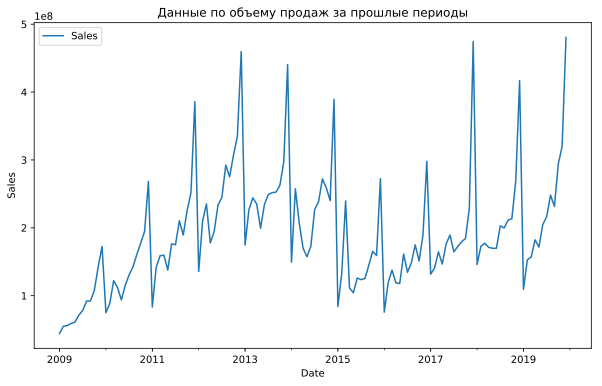

In [6]:
ax = df.plot(figsize=(10, 6))
ax.set_xlabel("Date")
ax.set_ylabel("Sales")

plt.title('Данные по объему продаж за прошлые периоды')
plt.show()

### Построение прогноза и выбор лучшей модели прогнозирования.
Для посторения прогноза будем использовать Тройное экспоненциальное сглаживание по методу Хольта-Винтерса. Для этого возьмем функцию ExponentialSmoothing из библиотеки statsmodels. Нам не придется тратить время на написание функции, мы только подберем наиболее подходящие параметры.

На графике представленном ниже показаны существующие данные, данные рассчитанные с помощью функции с разными параметрами и прогноз на 13 месяцев вперед ( с декабря 2019 до декабря 2020).

In [7]:
train = df[:106]

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 106 entries, 2009-01 to 2017-10
Freq: M
Data columns (total 1 columns):
Sales    106 non-null float64
dtypes: float64(1)
memory usage: 1.7 KB


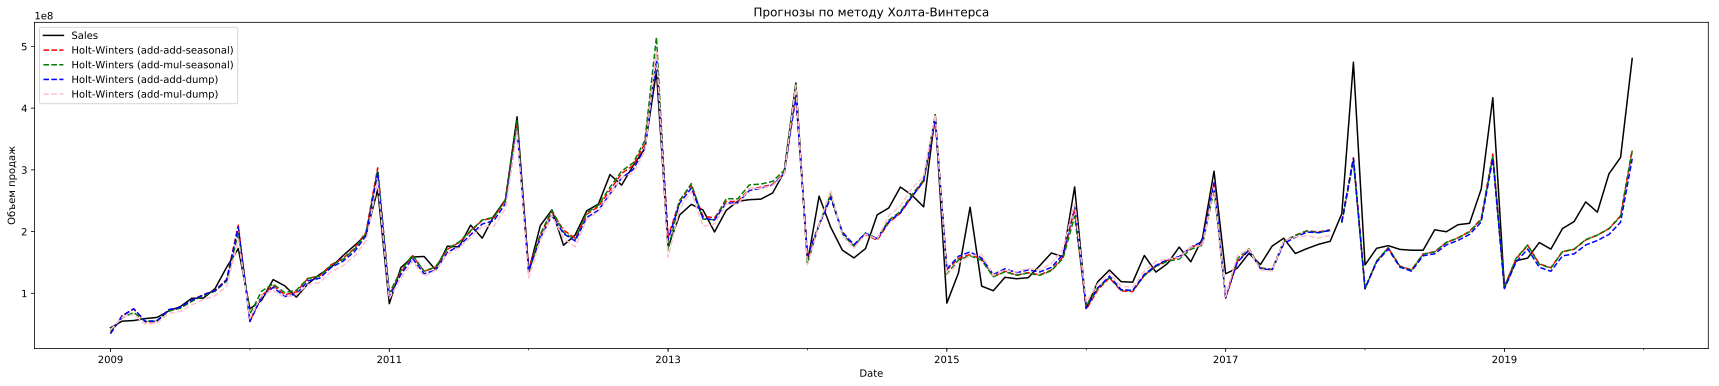

In [9]:
# Аддитивный тренд, Аддитивный сезон season_length=12 и использование преобразования Бокса-Кокса
fit1 = ExponentialSmoothing(train.Sales, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)

# Аддитивный тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса
fit2 = ExponentialSmoothing(train.Sales, seasonal_periods=12, trend='add', seasonal='mul').fit(use_boxcox=True)

# Аддитивный демпфированный тренд, аддитивный сезонный период season_length=12 и использование преобразования Бокса-Кокса
fit3 = ExponentialSmoothing(train.Sales, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)

# Аддитивный затухающий тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса.
fit4 = ExponentialSmoothing(train.Sales, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)

results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = df.plot(figsize=(30,6), color='black', title="Прогнозы по методу Холта-Винтерса" )
ax.set_ylabel("Объем продаж")
ax.set_xlabel("Date")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')
fit3.fittedvalues.plot(ax=ax, style='--', color='blue')
fit4.fittedvalues.plot(ax=ax, style='--', color='pink')

fit1.forecast(26).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', color='red', legend=True)
fit2.forecast(26).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', color='green', legend=True)
fit3.forecast(26).rename('Holt-Winters (add-add-dump)').plot(ax=ax, style='--', color='blue', legend=True)
fit4.forecast(26).rename('Holt-Winters (add-mul-dump)').plot(ax=ax, style='--', color='pink', legend=True)
plt.show()

### Таблица параметров
Данная таблица позволит сравнить результаты и параметризацию. Где

$\alpha$ - коэффициент сглаживания ряда

$\beta$ - коэффициент сглаживания тренда

$\gamma$ - коэффициент сглаживания сезонности

$l_0$ - начальный уровень

$b_0$ - начальный тренд

$SSE$ - сумма квадратов ошибок

In [10]:
results

,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,0.3790,0.3879,0.3522,0.5139
$\beta$,0.1127,0.0939,0.1048,0.0526
$\gamma$,0.0000,0.0000,0.0000,0.0000
$l_0$,874.5875,924.9938,866.1085,924.9941
$b_0$,9.3617,12.0786,13.4652,nan
SSE,"48,873,118,350,817,344.0000","50,165,907,017,619,696.0000","46,272,872,616,354,664.0000","47,466,932,497,988,560.0000"


### Результаты расчета

Посмотрим более наглядно исходные значения $y_t$, уровень $l_t$, тренд $b_t$, сезон $s_t$ и подогнанные значения $\hat{y}_t$ для этих моделей.

##### 1.Аддитивный тренд, Аддитивный сезон season_length=12 и использование преобразования Бокса-Кокса

In [11]:
df1 = pd.DataFrame(np.c_[train.Sales, fit1.level, fit1.slope, fit1.season, fit1.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=train.index)
df1.append(fit1.forecast(12).rename(r'$\hat{y}_t$').to_frame(), sort=True)
df1.tail()

,$y_t$,$l_t$,$b_t$,$s_t$,$\hat{y}_t$
Date,,,,,
2017-06,"189,281,378.8000","236,699,173.3184","-236,697,973.0347","-50,641,724.6677","183,465,888.1519"
2017-07,"164,530,262.4000","228,583,421.9784","-228,582,209.3129","-48,133,145.9916","193,917,934.0420"
2017-08,"172,492,036.7000","219,868,154.1359","-219,866,956.7107","-31,095,967.9202","201,203,834.9826"
2017-09,"179,425,247.9000","213,693,829.4831","-213,692,648.4835","-22,553,827.2712","199,544,910.5059"
2017-10,"184,335,552.0000","207,445,648.1237","-207,444,478.9644","-11,990,597.8544","202,950,370.4492"


##### 2. Аддитивный тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса

In [12]:
df2 = pd.DataFrame(np.c_[train.Sales, fit2.level, fit2.slope, fit2.season, fit2.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=train.index)
df2.append(fit2.forecast(26).rename(r'$\hat{y}_t$').to_frame(), sort=True)
df2.tail()

,$y_t$,$l_t$,$b_t$,$s_t$,$\hat{y}_t$
Date,,,,,
2017-06,"189,281,378.8000","337,115,974.9305","-337,114,636.6783",0.5520,"184,081,945.4015"
2017-07,"164,530,262.4000","322,913,732.4978","-322,912,381.5629",0.5641,"193,962,330.1729"
2017-08,"172,492,036.7000","308,875,004.1986","-308,873,673.3461",0.6139,"201,062,950.5343"
2017-09,"179,425,247.9000","299,863,681.7659","-299,862,371.1331",0.6364,"198,296,658.5771"
2017-10,"184,335,552.0000","291,192,280.5363","-291,190,983.1963",0.6691,"201,699,577.2923"


##### 3. Аддитивный демпфированный тренд, аддитивный сезонный период season_length=12 и использование преобразования Бокса-Кокса

In [13]:
df3 = pd.DataFrame(np.c_[train.Sales, fit3.level, fit3.slope, fit3.season, fit3.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=train.index)
df3.append(fit3.forecast(26).rename(r'$\hat{y}_t$').to_frame(), sort=True)
df3.tail()

,$y_t$,$l_t$,$b_t$,$s_t$,$\hat{y}_t$
Date,,,,,
2017-06,"189,281,378.8000","234,872,460.7683","-234,871,264.9471","-50,673,898.2172","180,615,695.3939"
2017-07,"164,530,262.4000","227,835,817.6093","-227,834,609.5976","-48,198,481.6448","190,845,418.6933"
2017-08,"172,492,036.7000","219,862,905.0898","-219,861,710.3585","-31,441,318.0453","199,163,611.2298"
2017-09,"179,425,247.9000","213,992,322.6458","-213,991,142.8407","-22,965,174.5422","198,404,114.6582"
2017-10,"184,335,552.0000","207,958,600.6647","-207,957,431.9627","-12,429,549.9597","202,238,220.6255"


##### 4. Аддитивный затухающий тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса.

In [14]:
df4 = pd.DataFrame(np.c_[train.Sales, fit4.level, fit4.slope, fit4.season, fit4.fittedvalues],
                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=train.index)
df4.append(fit4.forecast(26).rename(r'$\hat{y}_t$').to_frame(), sort=True)
df4.tail()

,$y_t$,$l_t$,$b_t$,$s_t$,$\hat{y}_t$
Date,,,,,
2017-06,"189,281,378.8000","301,092,092.4747","-301,090,799.7255",0.6226,"185,523,745.1227"
2017-07,"164,530,262.4000","278,629,505.0097","-278,628,208.1494",0.6365,"191,642,510.0123"
2017-08,"172,492,036.7000","262,871,993.6027","-262,870,727.2977",0.6940,"193,361,463.7788"
2017-09,"179,425,247.9000","255,522,441.1747","-255,521,197.3392",0.7214,"189,643,738.3806"
2017-10,"184,335,552.0000","248,949,124.0585","-248,947,891.0234",0.7591,"193,959,253.5491"


#### Теперь, посмотрим на уровни, тренды и сезонные компоненты моделей.

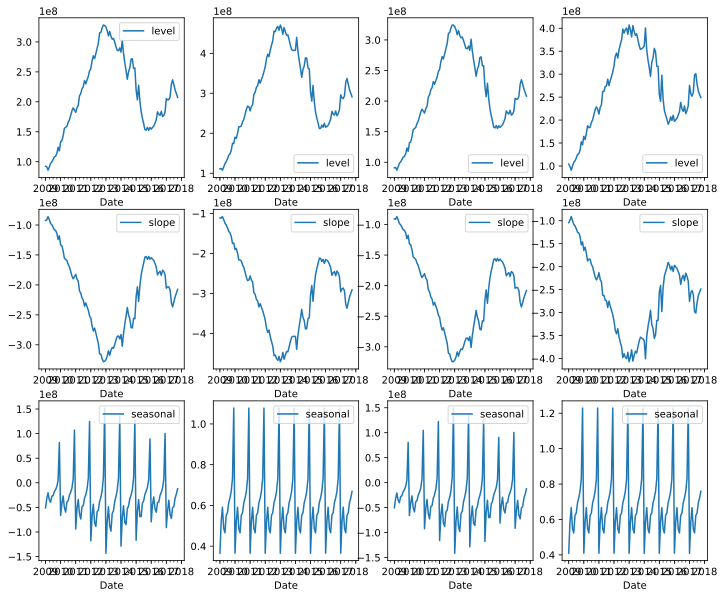

In [15]:
states1 = pd.DataFrame(np.c_[fit1.level, fit1.slope, fit1.season], columns=['level','slope','seasonal'], index=train.index)
states2 = pd.DataFrame(np.c_[fit2.level, fit2.slope, fit2.season], columns=['level','slope','seasonal'], index=train.index)
states3 = pd.DataFrame(np.c_[fit3.level, fit3.slope, fit3.season], columns=['level','slope','seasonal'], index=train.index)
states4 = pd.DataFrame(np.c_[fit4.level, fit4.slope, fit4.season], columns=['level','slope','seasonal'], index=train.index)

fig, [[ax1, ax4, ax7, ax10],[ax2, ax5, ax8, ax11], [ax3, ax6, ax9, ax12]] = plt.subplots(3, 4, figsize=(12,10))

states1[['level']].plot(ax=ax1)
states1[['slope']].plot(ax=ax2)
states1[['seasonal']].plot(ax=ax3)

states2[['level']].plot(ax=ax4)
states2[['slope']].plot(ax=ax5)
states2[['seasonal']].plot(ax=ax6)

states3[['level']].plot(ax=ax7)
states3[['slope']].plot(ax=ax8)
states3[['seasonal']].plot(ax=ax9)

states4[['level']].plot(ax=ax10)
states4[['slope']].plot(ax=ax11)
states4[['seasonal']].plot(ax=ax12)

plt.show()

### Оценка точности прогноза.

Cначала рассчитаем сумму квадратов $y_t$.

In [16]:
sum_y_t2 = sum(np.square(train['Sales']))
sum_y_t2

4.1478429865926636e+18

Теперь рассчитаем точность для моделей fit3 и fit4.

In [17]:
accuracy = pd.DataFrame(columns=["Additive", 'Multiplicative', 'Additive Dam', 'Multiplica Dam'], 
                        index=['Model error', 'Accuracy'])
accuracy["Additive"] = [(fit1.sse / sum_y_t2), (1 - (fit1.sse / sum_y_t2))]
accuracy["Multiplicative"] = [(fit2.sse / sum_y_t2), (1 - (fit2.sse / sum_y_t2))]
accuracy["Additive Dam"] = [(fit3.sse / sum_y_t2), (1 - (fit3.sse / sum_y_t2))]
accuracy["Multiplica Dam"] = [(fit4.sse / sum_y_t2), (1 - (fit4.sse / sum_y_t2))]

##### Таблица отклонений ошибки модели от прогнозной модели и точность прогноза

In [18]:
accuracy

,Additive,Multiplicative,Additive Dam,Multiplica Dam
Model error,0.0118,0.0121,0.0112,0.0114
Accuracy,0.9882,0.9879,0.9888,0.9886


Исходя из полученной информации, я остановлю свой выбор на модели со следующими параметрами: аддитивный затухающий тренд, мультипликативный сезонный период season_length=12 и использование преобразования Бокса-Кокса. Точность данной модели составляет __98,52%__

In [19]:
fit3.params

{'smoothing_level': 0.3521632953439904,
 'smoothing_slope': 0.10484334368013373,
 'smoothing_seasonal': 0.0,
 'damping_slope': 0.9495912591146818,
 'initial_level': 866.1085037477396,
 'initial_slope': 13.465221884980433,
 'initial_seasons': array([-211.89852454, -108.84282806,  -65.49789985, -127.0632933 ,
        -141.77217522,  -87.59374801,  -80.84169713,  -52.67076884,
         -39.08611041,  -21.2467609 ,   13.1642094 ,  162.28483688]),
 'use_boxcox': True,
 'lamda': 0.3067396824765302,
 'remove_bias': False}

На основании полученных результатов подберем параметра альфа и бета для нашей модели

In [20]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [21]:
alfa = np.arange(0.0, 1.0, 0.01)
beta = np.arange(0.0, 1.0, 0.01)

from itertools import product

parameters = product(alfa, beta)
parameters_list = list(parameters)
len(parameters_list)

10000

In [23]:
%%time
results = []
best_aic = float("inf")

for param in log_progress(parameters_list, every=5):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=ExponentialSmoothing(train.Sales, seasonal_periods=12, 
                                   trend='add', seasonal='add', damped=True).fit(smoothing_level=param[0], 
                                                                                 smoothing_slope=param[1], use_boxcox=True)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic, model.sse])

warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic', 'sse']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters        aic                         sse
3901  (0.39, 0.01) 3,606.5435 45,966,078,776,243,704.0000
3802  (0.38, 0.02) 3,606.5563 45,971,606,876,520,880.0000
3902  (0.39, 0.02) 3,606.5677 45,976,571,976,242,784.0000
4001   (0.4, 0.01) 3,606.5718 45,978,320,562,616,376.0000
3801  (0.38, 0.01) 3,606.5865 45,984,717,440,319,736.0000
Wall time: 3min 53s


In [21]:
fit = ExponentialSmoothing(train.Sales, seasonal_periods=12, 
                                   trend='add', seasonal='add', damped=True).fit(smoothing_level=0.34, 
                                                                                 smoothing_slope=0.1, use_boxcox=True)

In [22]:
train = train.append(fit.forecast(26).rename('Sales').to_frame(), sort=True)

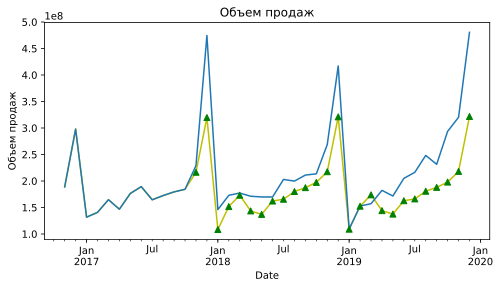

In [23]:
ax = train[94:132].plot(figsize=(8,4), color='y', title="Объем продаж", legend=False)
ax.set_ylabel("Объем продаж")
ax.set_xlabel("Date")

df[94:132].plot(ax=ax, legend=False)
train[106:132].plot(ax=ax, style='g^', legend=False)

plt.show()

In [25]:
train.tail(12)

,Sales
2019-01,"109,013,839.2950"
2019-02,"152,430,939.6928"
2019-03,"173,825,856.9338"
2019-04,"144,076,609.9367"
2019-05,"137,543,614.4945"
2019-06,"162,768,989.5408"
2019-07,"166,140,956.1649"
2019-08,"180,666,374.8259"
2019-09,"187,970,803.2832"
2019-10,"197,887,342.2112"
